# Analisi dei consumi energetici anello di teleriscaldamento
calcolo per simulatore consumi energetici

In [2]:
import pandas as pd 
import datetime 
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import numpy as np

## Caricamento dei dati

### Caricamento dati da CLOE Energyteams

In [3]:
data = pd.read_csv("Te_riscPad_31122022071231.csv",
                 sep = ";",
                 skiprows = 2,
                 usecols=["day","time", "(D)Energia Termica Edificio D", "Temperatura Ambiente"])

data.columns = ["day", "time", "temp", "energy"]
data['day_time'] = pd.to_datetime(data['day'] + data['time'], format='%d-%m-%Y%H:%M:%S')
data['energy'] = data.energy/1000
data

,day,time,temp,energy,day_time
0,01-01-2018,00:00:00,0.00,0.0,2018-01-01 00:00:00
1,01-01-2018,01:00:00,0.00,0.0,2018-01-01 01:00:00
2,01-01-2018,02:00:00,0.00,0.0,2018-01-01 02:00:00
3,01-01-2018,03:00:00,0.00,0.0,2018-01-01 03:00:00
4,01-01-2018,04:00:00,0.00,0.0,2018-01-01 04:00:00
...,...,...,...,...,...
43795,30-12-2022,19:00:00,10.82,2.0,2022-12-30 19:00:00
43796,30-12-2022,20:00:00,10.82,0.0,2022-12-30 20:00:00
43797,30-12-2022,21:00:00,10.82,7.5,2022-12-30 21:00:00
43798,30-12-2022,22:00:00,10.82,52.0,2022-12-30 22:00:00


In [4]:
# crea nuove colonne anno, mese, giorno, giorno della settimana e dell'anno
data['year'] =  data.day_time.dt.year
data['month'] = data.day_time.dt.month 
data['dd'] =    data.day_time.dt.day 
data['dw'] =    data.day_time.dt.day_of_week +1
data['dy'] =    data.day_time.dt.day_of_year
data['hh'] =    data.day_time.dt.hour

### Definizione dei prezzi 

In [5]:
prezzo_min = 0.20
prezzo_med = 0.30
prezzo_max = 0.40

## Simulazione delle temperature

4368


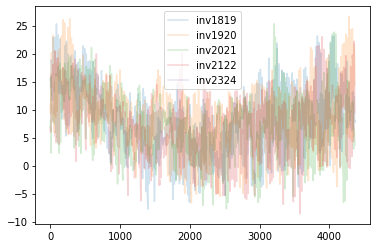

In [6]:
data['stagione'] = "-"
anni = [2018,2019,2020,2021,2022,2023]
stagioni = ["inv1819" ,"inv1920" ,"inv2021" ,"inv2122", "inv2223","inv2324"]

tempinv = pd.DataFrame( columns = stagioni ) 
nn = 182*24
print(nn)
nulls = list(["NaN"]*nn) 

for i in range(0,5):
    data.loc[ (data.year == anni[i])   & (data.dy > 287) , "stagione"] = stagioni[i]  
    data.loc[ (data.year == anni[i]+1) & (data.dy < 106) , "stagione"] = stagioni[i]
    x =  data.loc[ data.stagione == stagioni[i] ].temp.head(nn).to_list()
    x = x + nulls
    tempinv[ stagioni[i] ] = x[0:nn]

tempinv.reset_index(inplace=True)
tempinv['week'] = tempinv['index'] // (7*24)
tempinv.drop(columns=["index"], inplace=True)  
tempinv[stagioni].plot(alpha = .2)
nsim = 200
cols = ["sim"+ str(i) for i in range(1,nsim+1)]

tempinv_sim = pd.DataFrame(columns = cols)
 
for s in range(0,nsim):
    x = []
    for w in range(1,26):
        weeklytemp = tempinv[ tempinv.week == w] 
        i = random.randint(0,3)
        x = x + weeklytemp[ stagioni[ i ] ].to_list()
    tempinv_sim[cols[s]] = x
         
tempinv.to_csv("temperature_misurate.csv")
tempinv_sim.to_csv("temperature_simulate.csv")


## Simulazione della regolazione dell'impianto

Definizione del lavorativoime di funzionamento
iniziamo con una suddivisione in due gruppi: 
- attivo a 20°C nominali
- attenuazione notturna e festiva

In [7]:
def imposta_ferie(data):
    data.loc[  data.dw >= 6 , "ferie"                                         ] = True   
    data.loc[ (data.month == 1 ) &  data.day.isin( (1,2,3,4,5,6)) , "ferie"   ] = True
    data.loc[ (data.month == 11) &  data.day.isin( (2,3,4)) , "ferie"         ] = True
    data.loc[ (data.month == 12) &  data.day.isin( (24,25,26,31)) , "ferie"   ] = True
    return data.ferie

In [8]:

data['ferie'] = False
data['ferie'] = imposta_ferie(data)

# orario lavorativo  
data['lavorativo'] =    False
data.loc[ (data.hh >= 6 ) &  (data.hh <= 18 ) , 'lavorativo']= True
data.loc[ (data.ferie == True) , 'lavorativo']= False

data['dotcolor'] = ["red" if we==True else "blue" for we in data.ferie]


<AxesSubplot:>

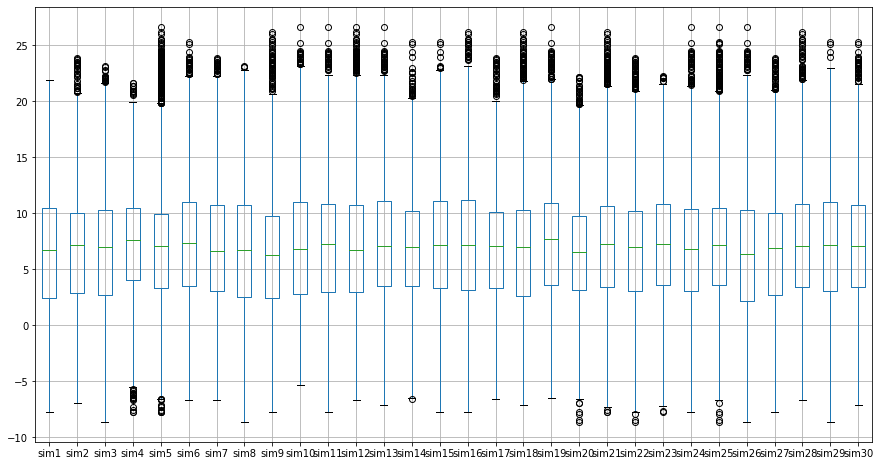

In [9]:
tempinv_sim[cols[0:30]].boxplot(figsize=(15,8))

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

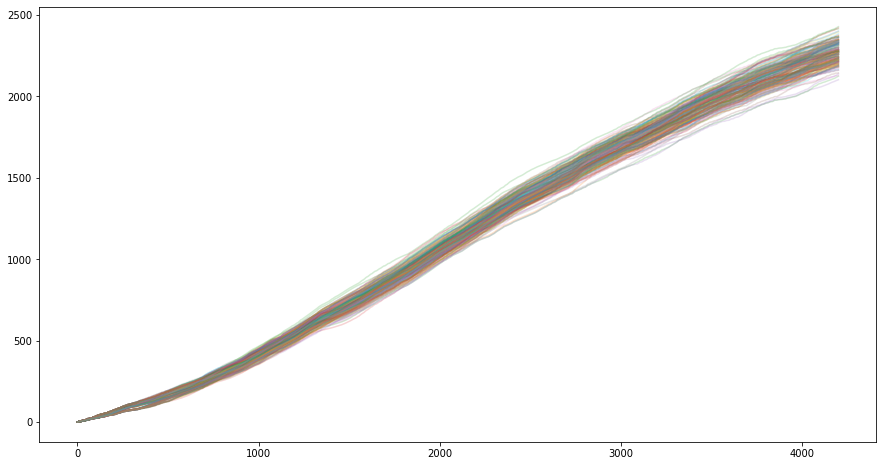

In [10]:
#gg simulati
sim_gg = pd.DataFrame(columns = cols)

for c in cols: 
    te = tempinv_sim[c].copy()
    te[ te > 20 ] = 20
    dt = 20 - te
    sim_gg[c] = dt.cumsum() / 24

plt.figure()  
sim_gg.plot(legend = False, figsize=(15,8), alpha = .2)

(array([ 3.,  5., 16., 33., 31., 44., 25., 30.,  9.,  4.]),
 array([2102.74708333, 2135.330875  , 2167.91466667, 2200.49845833,
        2233.08225   , 2265.66604167, 2298.24983333, 2330.833625  ,
        2363.41741667, 2396.00120833, 2428.585     ]),
 <BarContainer object of 10 artists>)

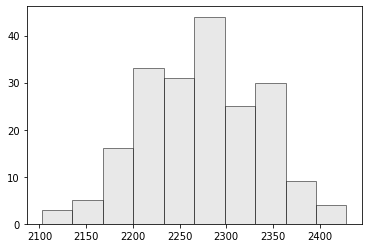

In [11]:
gg_simulati_inizio = sim_gg.tail(1).values.tolist()[0]
plt.hist(gg_simulati_inizio, color = "lightgray", edgecolor = "black", alpha = 0.5 )

In [12]:
# intrvallo di confidenza
gg_simulati_inizio.sort() 
xs = [round(x) for x in gg_simulati_inizio] 
print("minimo", xs[0] , " -  massimo", xs[99], "gradi giorno")
print("mediana: ", xs[50] , "gradi giorno")
print("intervallo di confidenza al 90%: ", xs[5]," - " , xs[94], "gradi giorno")

minimo 2103  -  massimo 2274 gradi giorno
mediana:  2228 gradi giorno
intervallo di confidenza al 90%:  2160  -  2271 gradi giorno


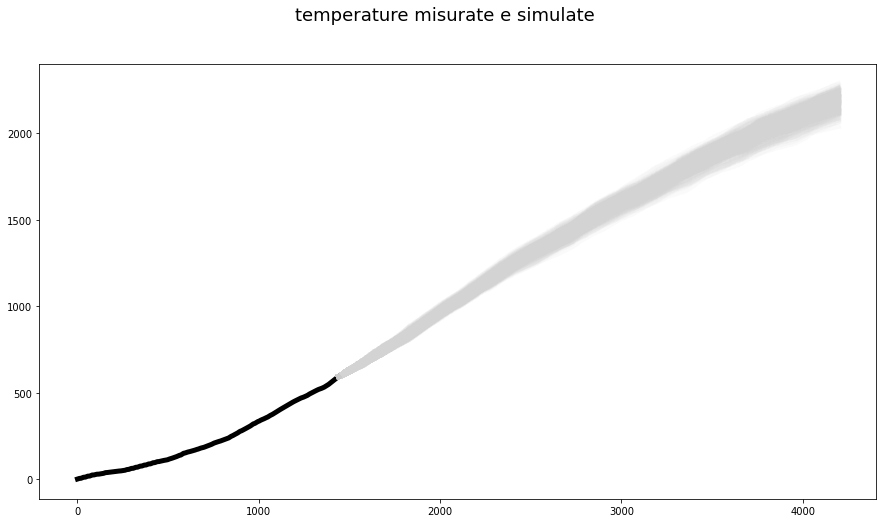

In [13]:
# serie composta da una parte misurata e una stimata
sim_gg_misti = pd.DataFrame(columns = cols)

limite =60*24
temp_misurate = tempinv["inv2223"]
temp_misurate = temp_misurate[0:limite].values
temp_misurate = [float(i) for i in temp_misurate]

for c in cols: 
    temp_simulate = tempinv_sim[c][limite+1:4199].values 
    temp_simulate = [float(i) for i in temp_simulate]
    te =  [  *temp_misurate , *temp_simulate ]
    te = [x if x < 20 else 20 for x in te]
    dt = [20 - x for x in te]
    sim_gg_misti[c] = pd.Series(dt).cumsum() / 24





plt.figure( figsize=(15,8))  
plt.plot(sim_gg_misti[0:limite].sim1,  alpha = 1, color = "black", linewidth=5)
plt.plot(sim_gg_misti[limite:4199],  alpha = .1, color = "lightgray", linewidth=5)
plt.suptitle('temperature misurate e simulate', fontsize=18)
plt.show()

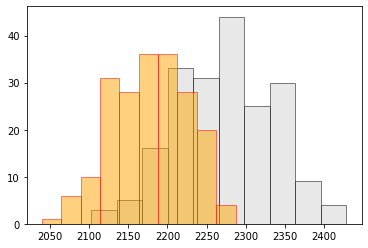

In [14]:

gg_simulati_dic = sim_gg_misti.tail(1).values.tolist()[0]

plt.hist(gg_simulati_inizio, color = "lightgray", edgecolor = "black", alpha = .5 , bins = 10 )
plt.hist(gg_simulati_dic, color = "orange", edgecolor = "red", alpha = 0.5, bins = 10 )
plt.show()

In [15]:
# intrvallo di confidenza
gg_simulati_dic.sort() 
xs = [round(x) for x in gg_simulati_inizio] 
  
print("minimo", xs[0] , " -  massimo", xs[nsim-1], "gradi giorno")
print("mediana: ", xs[nsim//2] , "gradi giorno")
print("intervallo di confidenza al 90%: ", xs[5]," - " , xs[nsim-5], "gradi giorno")

minimo 2103  -  massimo 2429 gradi giorno
mediana:  2275 gradi giorno
intervallo di confidenza al 90%:  2160  -  2396 gradi giorno


## Simulazione dei consumi energetici

### esplorazione: scatter plot temperature / consumi 

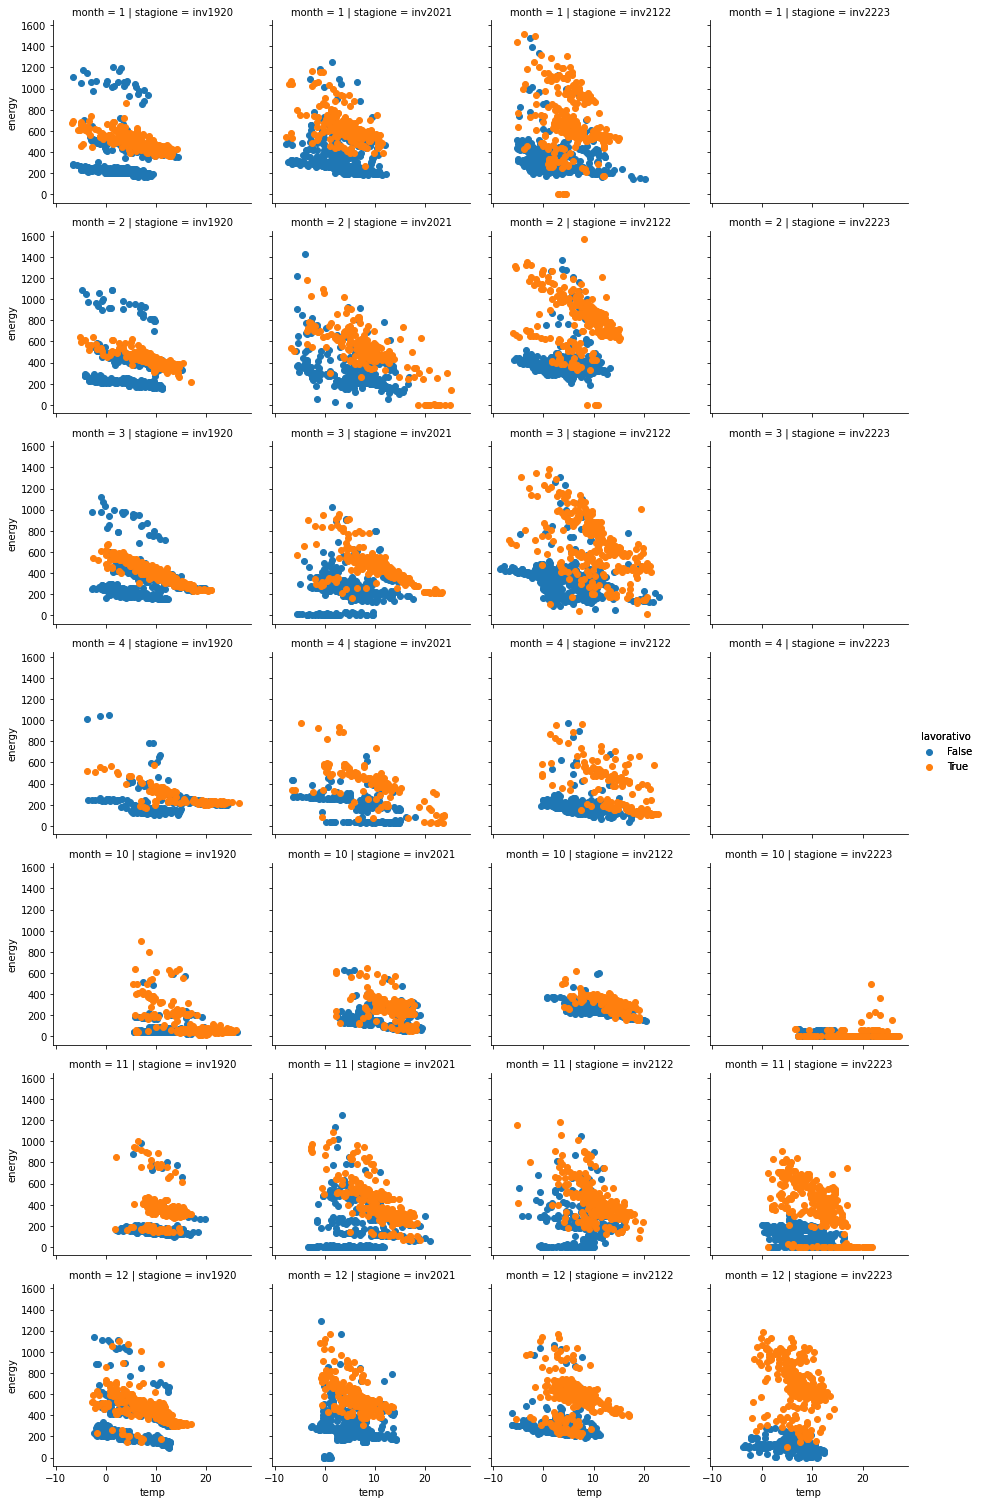

In [16]:
dplot = data[ data.stagione != "-" ]
dplot = dplot[ dplot.stagione != "inv1819" ]
dplot = dplot[["temp", "energy","stagione", "year", "month","ferie",'lavorativo']]
g = sns.FacetGrid(dplot, col="stagione",  row="month", hue='lavorativo').add_legend()
g = g.map(plt.scatter, "temp", "energy").add_legend()
plt.show()

## preparazione dati: aggiungo i 4 regimi di funzionamento

<AxesSubplot:>

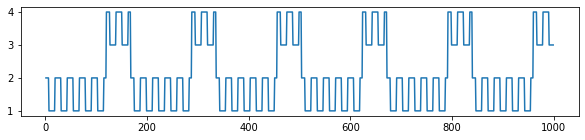

In [41]:
diurno = (data.hh >= 7) &  (data.hh <= 18)
notturno = - diurno
lav = (data.dw <= 5) & (-data.ferie)
fest = - lav
data['diurno'] = diurno
data['lav'] = lav
data['reg'] = 0 # spento
data.loc[   diurno & lav,  "reg"] = 1
data.loc[ notturno & lav,  "reg"] = 2
data.loc[   diurno & fest, "reg"] = 3
data.loc[ notturno & fest, "reg"] = 4

plt.figure(figsize = (10,2))
data.reg[1:1000].plot()

## Preparazione dati: selezione del dataset per la regressione lineare

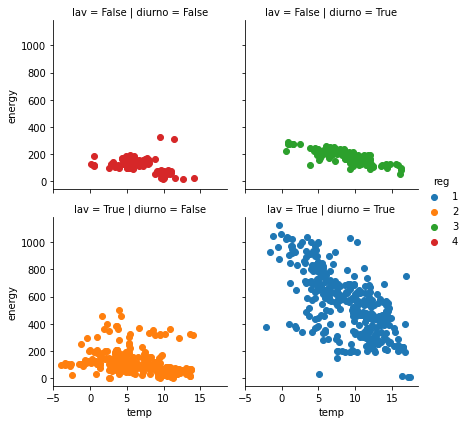

In [79]:
data_learn = data[ data.stagione == "inv2223" ]

# energy non negativa
data_learn = data_learn[ data_learn.energy > 1.0 ] 

# escludiamo periodi di spegnimento e test
gg_validi_nov = (data_learn.month == 11) & (data_learn.dd >=  7)  
gg_validi_dic = (data_learn.month == 12) & (data_learn.dd <= 16)  # dal 17 dic regime ulteriormente attenuato
data_learn = data_learn[ gg_validi_nov | gg_validi_dic ]
g = sns.FacetGrid(data_learn, row = "lav", col=  "diurno" , hue = "reg")
g = g.map(plt.scatter, "temp", "energy").add_legend()

## Pulizia dati
in questo modo fatta su tutti i dati, 
meglio sarebbe farla sulle 4 parti diurno / lavorativo

Pulizia per ciascuno dei regimi di funzionamento

In [81]:
from sklearn.cluster import DBSCAN

In [82]:
def identifica_outliers(Z, epsilon, minpoints, echo = False):
    
    #normalize by column
    Zn = (Z - Z.mean(axis = 0)) / Z.std(axis = 0)
    
    #identify clusters and "halo"
    clustering = DBSCAN(eps=epsilon, min_samples=minpoints).fit(Zn)
    is_halo = clustering.labels_ <  0
    
    Zh = Z[ is_halo] # points belong to HALO
    Zc = Z[~is_halo] # points belong to some cluster
    
    if echo:
        print("Punti identificati come halo: ", round(is_halo.mean()*100,1),"%")
        plt.figure(figsize= (5,5))
        plt.scatter(Zh[:,0], Zh[:,1], color = "lightgray", alpha = .2)
        plt.scatter(Zc[:,0], Zc[:,1], c = clustering.labels_[~is_halo],alpha = 1)
        plt.show()
        
    
       
    return(is_halo)

regime di funzionamento 1
Punti identificati come halo:  13.4 %


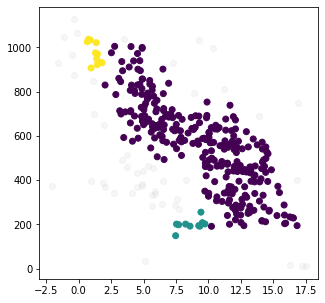

regime di funzionamento 2
Punti identificati come halo:  16.1 %


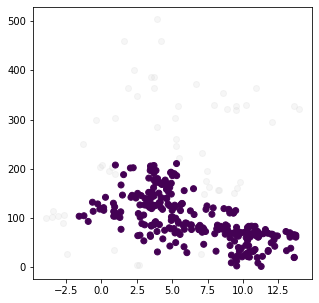

regime di funzionamento 3
Punti identificati come halo:  31.7 %


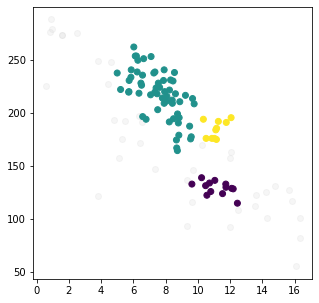

regime di funzionamento 4
Punti identificati come halo:  22.5 %


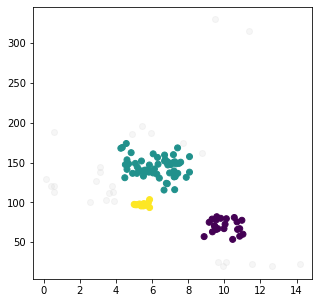

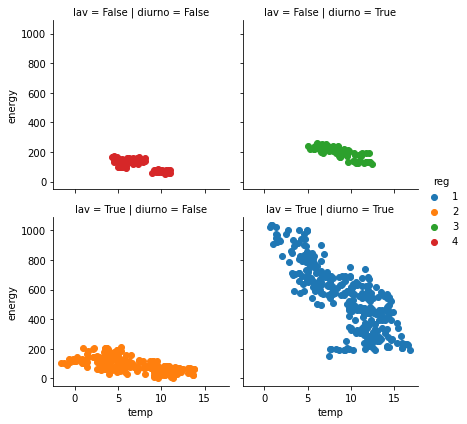

In [133]:
data_learn_clean = data_learn.head(0)
for i in range(1,5):
    print("regime di funzionamento", i)
    data_regime_i = data_learn.loc[ data_learn.reg == i ]
    zz = data_regime_i.loc[ : , ['temp', 'energy']].values
    outlier = identifica_outliers(zz, epsilon = 0.35, minpoints=10, echo = True)
    data_learn_clean = data_learn_clean.append(data_regime_i[ ~ outlier ])

 
g = sns.FacetGrid(data_learn_clean, row = "lav", col=  "diurno" , hue = "reg")
g = g.map(plt.scatter, "temp", "energy").add_legend()

data_learn_clean.to_csv('data_learn.csv')
    

### modello regressione lineare 
dataset di apprendimento: dal 1 novembre al 20 dicembre 2022

# modello

definiamo i dati da cui ricavare i modelli, con 4 regimi di funzionamento

rimuozione outliers

identifica gli outliers dei 4 gruppi
NB il diurno festivo ha due regimi diversi perchè è stata modificata la regolazione  tra novembre e dicembre

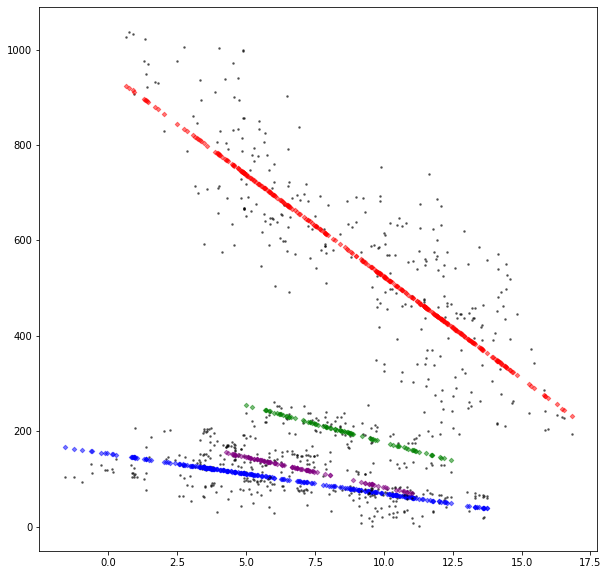

In [134]:

indice =  range(1,5)
modello = pd.DataFrame(index = indice)
modello['coeff'] = 0
modello['inter'] = 0
modello['score'] = 0
modello['colors'] = ("red","blue", "green", "purple")
modello['desc'] =   ("Lavorativo Diurno","Lavorativo Nottuno", "Festivo Diurno", "Festivo Notturno")

# data.loc[   diurno & lav,  "reg"] = 1
# data.loc[ notturno & lav,  "reg"] = 2
# data.loc[   diurno & fest, "reg"] = 3
# data.loc[ notturno & fest, "reg"] = 4


plt.figure(figsize = (10,10)) 



for i in indice:
    
    data_i = data_learn_clean[ data_learn_clean.reg == i].loc[ :, ['temp', 'energy']].values

    X = data_i[:,0].reshape(-1, 1)
    y = data_i[:,1]
      
    model = LinearRegression()
    model.fit(X, y)
    
    modello.loc[i, 'score'] = model.score(X, y).round(4)*100
    modello.loc[i, 'coeff'] = round(model.coef_[0],3)
    modello.loc[i, 'inter'] = round(model.intercept_,3)
     
    y_sim = X * modello.loc[i].coeff + modello.loc[i].inter
    
    
    plt.scatter( x = X, y = y, c="black",  marker = ".", s = 10,alpha = 0.5,)
    plt.scatter( x = X, y = y_sim, c=modello['colors'][i], marker = "D", s = 10,alpha = 0.5,)
    #plt.show()
     


   

In [135]:
modello

,coeff,inter,score,colors,desc
1,-42.786,952.535,61.51,red,Lavorativo Diurno
2,-8.347,153.342,40.99,blue,Lavorativo Nottuno
3,-15.560,333.054,64.45,green,Festivo Diurno
4,-12.614,209.654,50.85,purple,Festivo Notturno


In [147]:
# potrei anche fare un modello unoco di regessione

# X = data_learn_clean.loc[ :, ['temp', 'diurno', 'lav']].values.reshape(-1, 3)
# y = data_learn_clean.loc[ :, 'energy'].values
# print(X)               
# model = LinearRegression()
# model.fit(X, y)
# model.coef_, model.intercept_

# model.predict(np.array([[0,True,True]]))


[[10.02 True True]
 [14.57 True True]
 [14.16 True True]
 ...
 [5.3 False False]
 [5.39 False False]
 [5.07 False False]]


array([736.19424236])

# Validazione
confrontare i dati simulati e misurati sulla stagione 22 23

# previsione
applicare il modello al resto della stagione
pervedere consumi e costi

# aggiornamento
rendere più semplice l'aggiornamento dei modelli:
scarico settimanale (o giornaliero) delle musure di temperatura e consumo
aggiorno i 4 coefficienti di regressione